###### Ran with python 3.7 and installed all packages with miniconda

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

###### This section imports the spectogram, the the minimum and maxium values, then shifts the values to 0-255

(2097, 8000)


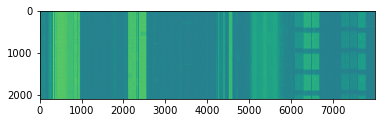

In [6]:
spectogram = cv2.imread('spectrogram.tif', -1)

type(spectogram)
spect_np = np.array(spectogram)
print(spect_np.shape)

spect_np = np.around(spect_np)
spect_np = spect_np.astype(np.uint8)
min = np.amin(spect_np)
spect_np = spect_np - min
plt.imshow(spect_np)

###### The loop here determines the best threshold value to use in the openCV threshold shape detection function 

In [21]:
test_results = np.empty([50,1])
for j in range(70, 120, 1):
    spect_thresh = cv2.threshold(spect_np, j, 255, cv2.THRESH_BINARY_INV)[1]
    spect_thresh = spect_thresh / 255
    spect_sums = spect_thresh.sum(axis=0)
    
    # this section of code pulls in the channel frequencies and creates a map
    # from the frequencies to the image, so the output of the threshold array 
    # can be summed into the proper bins
    spectrum = pd.read_csv('channel-metadata.csv')

    spectrum_range = spectrum['end_frequency'].max() - spectrum['start_frequency'].min()
    bin_scalar = len(spect_sums) / spectrum_range

    spectrum['start_shift'] = spectrum['start_frequency'] - spectrum['start_frequency'].min()
    start_scaled_shift = ((spectrum['start_shift'] * bin_scalar).round().to_numpy()).astype(int)
    spectrum['end_shift'] = spectrum['end_frequency'] - spectrum['start_frequency'].min()
    end_scaled_shift = (spectrum['end_shift'] * bin_scalar).round().to_numpy().astype(int)

    np_sums = np.empty([len(end_scaled_shift), 1])
    
    # this loop takes all of the scaled bins' upper and lower bounds and creates
    # a new array of summed values from threshold array
    for i in range(len(end_scaled_shift)):
        indices = [start_scaled_shift[i], (end_scaled_shift[i] - 1)]
        np_sums[i] = spect_sums[indices].sum()
    
    # the optimal threshold will best distinguish between a block of spectrum 
    # that is occupied vs. unoccupied, setting all occupied to 0 and unoccupied
    # to 255, the largest mean difference shows the threshold that is most accurate
    spectrum['bin_totals'] = np_sums
    spectrum_test = spectrum.groupby('occupied')['bin_totals'].mean()
    test_results[j - 70, 0] = spectrum_test.max()-spectrum_test.min()

threshold = np.where(test_results == np.amax(test_results))
threshold = (threshold[0] + 70).astype(int)

###### This reruns the above loop with the best threshold value

In [36]:
spect_thresh = cv2.threshold(spect_np, threshold, 255, cv2.THRESH_BINARY_INV)[1]
spect_thresh = spect_thresh / 255
spect_sums = spect_thresh.sum(axis=0)

spectrum = pd.read_csv('channel-metadata.csv')

spectrum_range = spectrum['end_frequency'].max() - spectrum['start_frequency'].min()

bin_scalar = len(spect_sums) / spectrum_range
spectrum['start_shift'] = spectrum['start_frequency'] - spectrum['start_frequency'].min()
start_scaled_shift = ((spectrum['start_shift'] * bin_scalar).round().to_numpy()).astype(int)
spectrum['end_shift'] = spectrum['end_frequency'] - spectrum['start_frequency'].min()
end_scaled_shift = (spectrum['end_shift'] * bin_scalar).round().to_numpy().astype(int)

np_sums = np.empty([len(end_scaled_shift), 1])

for i in range(len(end_scaled_shift)):
    indices = [start_scaled_shift[i], (end_scaled_shift[i] - 1)]
    np_sums[i] = spect_sums[indices].sum()

0.8181818181818182


###### Finally, a cutoff of the bin totals is used to predict if a channel is occupied or not

In [ ]:
spectrum['bin_totals'] = np_sums
spectrum['spectrum_predict'] = 'no'
spectrum.loc[spectrum.bin_totals < 3800, 'spectrum_predict'] = 'yes'
spectrum['correct'] = 0
spectrum.loc[spectrum.occupied == spectrum.spectrum_predict, 'correct'] = 1
print((spectrum['correct']).mean())

###### The algorithm was able to get 82% accuracy
